In [1]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [2]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [3]:
import scipy

def loadFeaturesAndNormalize(sessionPath):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data

In [4]:
import os

def getDataset(fileName):
    session_data = loadFeaturesAndNormalize(fileName)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [5]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

dataDir = '/Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData'

for dayIdx in range(len(sessionNames)):
    print(dayIdx)
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat')
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat')

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat')
        competitionDatasets.append(dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [6]:
dataDir = '/Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData'

competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]


In [7]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

with open('/Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData/ptDecoder_ctc', 'wb') as handle:
    pickle.dump(allDatasets, handle)

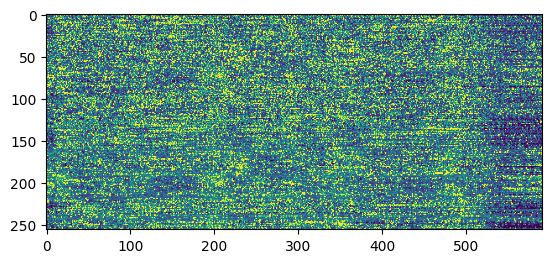

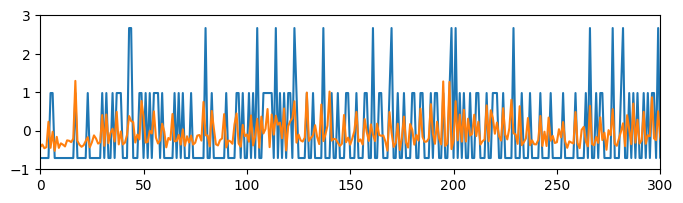

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(trainDatasets[0]['sentenceDat'][10].T, clim=[-1,1])
plt.show()

plt.figure(figsize=(8,2))
plt.plot(trainDatasets[0]['sentenceDat'][10][:,0])
plt.plot(trainDatasets[0]['sentenceDat'][10][:,128])
plt.xlim([0,300])
plt.ylim([-1,3])
plt.show()

In [9]:
import numpy as np
import scipy.io
import os
import pickle
import re
from g2p_en import G2p

# --- 1. Helper Functions ---

def compute_deltas(features, width=3):
    """
    Computes delta (velocity) or double-delta (acceleration) features.
    Uses a simple central difference window.
    """
    n_frames, n_dims = features.shape
    deltas = np.zeros_like(features)
    
    # Pad features to handle boundaries (replicate edge values)
    padded = np.pad(features, ((1, 1), (0, 0)), mode='edge')
    
    # Compute central difference: f(t+1) - f(t-1)
    # We can also use a wider window for smoother derivatives
    for i in range(n_frames):
        deltas[i] = (padded[i+2] - padded[i]) / 2.0
        
    return deltas

def load_and_process_data(sessionPath, apply_log=False, apply_deltas=False):
    """
    Loads .mat data, applies optional Log transform and Deltas, 
    then performs block-wise Z-score normalization.
    """
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    
    n_trials = dat['sentenceText'].shape[0]

    # --- Step 1: Extract Features ---
    for i in range(n_trials):    
        # Concatenate area 6v tx1 and spikePow
        # Assuming first 128 are tx1, next 128 are spikePow
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        # --- Step 2: Log Transform (Optional) ---
        if apply_log:
            # Apply log only to spikePow (indices 128 to 256)
            # Add epsilon to prevent log(0)
            epsilon = 1e-8
            features[:, 128:] = np.log(features[:, 128:] + epsilon)

        # --- Step 3: Compute Deltas (Optional) ---
        if apply_deltas:
            # Velocity
            d1 = compute_deltas(features)
            # Acceleration (Delta of Velocity)
            d2 = compute_deltas(d1)
            # Concatenate all: [Static, Velocity, Acceleration]
            features = np.concatenate([features, d1, d2], axis=1)

        sentence = dat['sentenceText'][i].strip()
        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(features.shape[0])

    # --- Step 4: Block-wise Normalization ---
    # Normalize the features (static + deltas) to have 0 mean and 1 std per block
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    
    for b in blockList:
        sentIdx = np.where(blockNums == b)[0]
        
        # Collect all frames in this block to compute stats
        block_feats = np.concatenate([input_features[i] for i in sentIdx], axis=0)
        
        # Compute mean and std
        feats_mean = np.mean(block_feats, axis=0, keepdims=True)
        feats_std = np.std(block_feats, axis=0, keepdims=True)
        
        # Apply normalization
        for i in sentIdx:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    return {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

# --- 2. Main Processing Loop ---

def create_dataset_variant(session_names, data_dir, variant_name, apply_log, apply_deltas):
    print(f"Processing dataset variant: {variant_name} (Log={apply_log}, Deltas={apply_deltas})...")
    
    datasets = {'train': [], 'test': [], 'competition': []}
    
    for session in session_names:
        # Process Train
        train_data = load_and_process_data(os.path.join(data_dir, 'train', session + '.mat'), apply_log, apply_deltas)
        datasets['train'].append(getDataset_from_data(train_data)) # Re-using your existing structure logic
        
        # Process Test
        test_data = load_and_process_data(os.path.join(data_dir, 'test', session + '.mat'), apply_log, apply_deltas)
        datasets['test'].append(getDataset_from_data(test_data))
        
        # Process Competition (if exists)
        comp_path = os.path.join(data_dir, 'competitionHoldOut', session + '.mat')
        if os.path.exists(comp_path):
            comp_data = load_and_process_data(comp_path, apply_log, apply_deltas)
            datasets['competition'].append(getDataset_from_data(comp_data))
            
    # Save Pickle
    save_path = os.path.join(data_dir, f'ptDecoder_ctc_{variant_name}')
    with open(save_path, 'wb') as handle:
        pickle.dump(datasets, handle)
    print(f"Saved {save_path}")

# Helper to format data into your final dictionary structure (Phonemes, etc.)
# This logic is copied/adapted from your original getDataset function
def getDataset_from_data(session_data):
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        # Phoneme processing
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        
        phonemes = []
        for p in g2p(thisTranscription):
            if p == ' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p) 
            if re.match(r'[A-Z]+', p):
                phonemes.append(p)
        phonemes.append('SIL') # End token

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        # phoneToId needs to be available from your previous cell
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes] 
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    # Lengths
    timeSeriesLens = [x.shape[0] for x in allDat]
    phoneLens = [np.argwhere(x == 0)[0, 0] for x in seqElements]
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    return newDataset

# --- 3. Run All Variants ---

# Define your paths
dataDir = '/Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData'

# 1. Base (Raw features only)
create_dataset_variant(sessionNames, dataDir, "raw", apply_log=False, apply_deltas=False)

# 2. Log (Raw + Log Transform)
create_dataset_variant(sessionNames, dataDir, "log", apply_log=True, apply_deltas=False)

# 3. Log + Deltas (Raw + Log + Velocity + Acceleration)
create_dataset_variant(sessionNames, dataDir, "log_delta", apply_log=True, apply_deltas=True)

Processing dataset variant: raw (Log=False, Deltas=False)...
Saved /Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData/ptDecoder_ctc_raw
Processing dataset variant: log (Log=True, Deltas=False)...
Saved /Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData/ptDecoder_ctc_log
Processing dataset variant: log_delta (Log=True, Deltas=True)...
Saved /Users/sujitsilas/Desktop/UCLA/07 Fall 2025/EC ENGR 243A Neural Signal Processing/Project/neural_seq_decoder/competitionData/ptDecoder_ctc_log_delta
